# Nested Leave-One-Issue-Out Cross Validation For Logistic Regression On Textual Features using class_weight=balanced

In [1]:
import numpy as np
import pandas as pd
import xlrd as xl
from pandas import ExcelWriter
from pandas import ExcelFile
import pprint
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
import re
import pickle
from operator import itemgetter
import time, datetime
from functools import partial, update_wrapper
from openpyxl import load_workbook

from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Imb_Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, LeaveOneGroupOut
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score, make_scorer, confusion_matrix

pp = pprint.PrettyPrinter(indent=4)

## Ignore warnings
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
np.warnings.filterwarnings('ignore')

#### Use spaCy parser for word tokenization of a sentence:

In [2]:
import spacy
eng = spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

#### Define stopwords as punctuation + common contractions:

In [3]:
from string import punctuation
from nltk.corpus import stopwords

stop_words = list(punctuation) + ["'s","'m","n't","'re","-","'ll",'...'] #+ stopwords.words('english')

#### Code to lemmatize and tokenize:

In [4]:
def get_lemma(item):
    return WordNetLemmatizer().lemmatize(item)

def tokenize(line):
    line_tokens = []
    tokens = parser(line)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            line_tokens.append('URL')
        elif token.orth_.startswith('@'):
            line_tokens.append('SCREEN_NAME')
        elif str(token) not in stop_words:
            line_tokens.append(get_lemma(token.lower_))
    return line_tokens

In [5]:
### Read from the pickled file

all_data = pd.read_pickle('../../data/text_conv_data.pkl')

print("Size of corpus: "+str(len(all_data)))

Size of corpus: 4330


In [90]:
all_data

,Document,Text Content,Code,len,tloc,cloc,tpos1,tpos2,clen,tlen,...,aa_MEMBER,aa_NONE,begauth_False,begauth_True,has_code_False,has_code_True,first_turn_False,first_turn_True,last_turn_False,last_turn_True
0,1 37_tensorflow.doc,Node.js (JavaScript) Wrapper API,Expected Behaviour,32,0.5,0.002294,0.0,1.000000,1.0,0.055556,...,0,1,0,1,1,0,0,1,1,0
1,1 37_tensorflow.doc,Because JavaScript is Awesome,Motivation,29,1.0,0.004587,0.0,1.000000,1.0,0.055556,...,0,1,0,1,1,0,0,1,1,0
2,1 37_tensorflow.doc,+1!,Social Conversation,3,1.0,0.006881,0.000026,0.999974,1.0,0.013889,...,0,1,1,0,1,0,1,0,1,0
3,1 37_tensorflow.doc,+1,Social Conversation,2,1.0,0.009174,0.000077,0.999923,1.0,0.013889,...,0,1,1,0,1,0,1,0,1,0
4,1 37_tensorflow.doc,:+1:,Social Conversation,4,1.0,0.011468,0.000135,0.999865,1.0,0.013889,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,15 15604_tensorflow.doc,You can check your graphic card with the comma...,Solution Discussion,50,0.75,0.987421,0.975879,0.024121,0.5,0.070866,...,0,1,1,0,1,0,1,0,1,0
314,15 15604_tensorflow.doc,CODE,Solution Discussion,4,1.0,0.990566,0.975879,0.024121,0.055556,0.007874,...,0,1,1,0,0,1,1,0,1,0
315,15 15604_tensorflow.doc,This works for me (tensorflow-gpu==1.8.0 and c...,Solution Discussion,86,1,0.993711,1.0,0.000000,14,0.110236,...,0,1,1,0,1,0,1,0,0,1
316,15 15604_tensorflow.doc,CODE,Solution Discussion,4,2,0.996855,1.0,0.000000,1,0.007874,...,0,1,1,0,0,1,1,0,0,1


<AxesSubplot:>

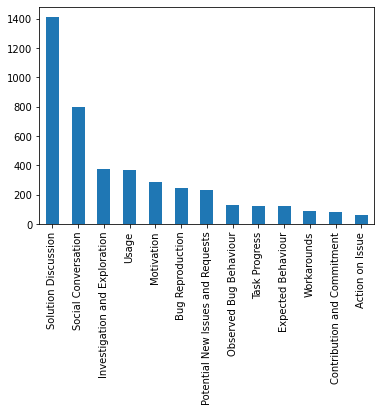

In [93]:
all_data["Code"].value_counts().plot.bar()

In [89]:
ls ..

data/                 preprocess_data.ipynb  test_environment.ipynb
logistic_regression/  random_forest/         transform_features.ipynb


In [130]:
train = pd.read_pickle('../data/train.pkl')
test = pd.read_pickle('../data/test.pkl')

print("Size of the train data: ", len(train))
print("Size of the test data: ", len(test))

Size of the train data:  3464
Size of the test data:  866


<AxesSubplot:>

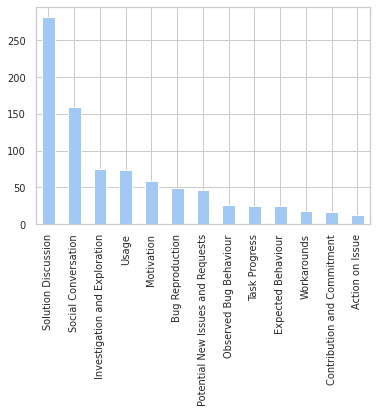

In [131]:
test["Code"].value_counts().plot.bar()

In [128]:
possible_labels = train["Code"].unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}


In [118]:
train['Code'] = train["Code"].replace(label_dict)
test['Code'] = test["Code"].replace(label_dict)

In [120]:
X = train['Text Content'].values
y = train['Code'].values


In [119]:
X_test = test['Text Content'].values
y_test = test['Code'].values

In [121]:
y

array([0, 1, 0, ..., 1, 3, 2])

# Nested Cross-Validation on Logistic Regression:

In [10]:
# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# To be used in outer CV
logo = LeaveOneGroupOut()
outer_cv = logo.split(X,y,groups=doc_groups)

NameError: name 'doc_groups' is not defined

## Define Pipelines

1. Pipeline1: tfidf + class_weight=balanced

In [122]:
pipeline1 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression(class_weight='balanced')),
])

### Hyperparameters to search
parameters = {
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'clf__C': (0.1, 0.1, 1, 10),
}

## Nested Cross Validation Using GridSearch

In [123]:
### Define and create the scoring functions

def score_func(y_true, y_pred, score_index, i):
    return(precision_recall_fscore_support(y_true,y_pred,labels=labels)[score_index][i])

def avg_score(y_true, y_pred, score_index):
    return precision_recall_fscore_support(y_true,y_pred,average='weighted')[score_index]

def sum_support(y_true, y_pred):
    return len(y_true)

### Create partials for each of the metrics returned
score_funcs = {v: partial(score_func, score_index=k) for k, v in {0:'precision',1:'recall',2:'fscore',3:'support'}.items()}
prec_score = partial(score_func, score_index=0)
update_wrapper(prec_score,score_func)
rec_score = partial(score_func, score_index=1)
update_wrapper(rec_score,score_func)
f_score = partial(score_func, score_index=2)
update_wrapper(f_score,score_func)
support_score = partial(score_func, score_index=3)
update_wrapper(support_score,score_func)

### Create a callable scoring function for each of the metrics for each classification label
scorer = {}
for label_id in range(0,13):
    scorer['label'+str(label_id)+'_precision'] = make_scorer(prec_score, i=label_id)
    scorer['label'+str(label_id)+'_recall'] = make_scorer(rec_score, i=label_id)
    scorer['label'+str(label_id)+'_fscore'] = make_scorer(f_score, i=label_id)
    scorer['label'+str(label_id)+'_support'] = make_scorer(support_score, i=label_id)

### Create a callable scoring function for avg/total of the metrics across classification labels
scorer['avg_precision'] = make_scorer(avg_score,score_index=0)
scorer['avg_recall'] = make_scorer(avg_score,score_index=1)
scorer['avg_fscore'] = make_scorer(avg_score,score_index=2)
scorer['total_support'] = make_scorer(sum_support)

### Perform Nested cross-validation on Pipeline1
start = time.time()
clf1 = GridSearchCV(pipeline1, parameters, scoring='f1_weighted')
clf1 = clf1.fit(X, y)
clf1_results = clf1.predict(X_test)
#clf1_results = cross_validate(clf1, X=X, y=y, cv=outer_cv, scoring=scorer)
print("Completed Pipeline1 scenario in "+ str(datetime.timedelta(seconds=(time.time()-start))))

Completed Pipeline1 scenario in 0:02:23.421820


In [124]:
from sklearn.metrics import f1_score
f1_score(y_test, clf1_results, average='weighted')

0.5121783698939905

In [125]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, clf1_results)

for i, label in enumerate(labels):
    print('{}: \t\tprecision: {:.2f}, recall: {:.2f}, fscore: {:.2f}, support: {}'.format(label, precision[i], recall[i], fscore[i], support[i]))

Solution Discussion: 		precision: 0.54, recall: 0.65, fscore: 0.59, support: 282
Expected Behaviour: 		precision: 0.48, recall: 0.40, fscore: 0.43, support: 25
Usage: 		precision: 0.44, recall: 0.46, fscore: 0.45, support: 74
Social Conversation: 		precision: 0.73, recall: 0.69, fscore: 0.71, support: 159
Contribution and Commitment: 		precision: 0.56, recall: 0.29, fscore: 0.38, support: 17
Bug Reproduction: 		precision: 0.48, recall: 0.45, fscore: 0.46, support: 49
Motivation: 		precision: 0.35, recall: 0.31, fscore: 0.33, support: 58
Potential New Issues and Requests: 		precision: 0.29, recall: 0.24, fscore: 0.26, support: 46
Investigation and Exploration: 		precision: 0.43, recall: 0.51, fscore: 0.47, support: 75
Workarounds: 		precision: 0.40, recall: 0.11, fscore: 0.17, support: 18
Observed Bug Behaviour: 		precision: 0.21, recall: 0.12, fscore: 0.15, support: 26
Task Progress: 		precision: 0.38, recall: 0.32, fscore: 0.35, support: 25
Action on Issue: 		precision: 0.88, recall: 

In [126]:
clf1.best_params_

{'clf__C': 10, 'vect__ngram_range': (1, 2)}

In [27]:
label_dict = {'Solution Discussion': 0, 'Expected Behaviour': 1, 'Usage': 2, 'Social Conversation': 3, 'Contribution and Commitment': 4, 'Bug Reproduction': 5, 'Motivation': 6, 'Potential New Issues and Requests': 7, 'Investigation and Exploration': 8, 'Workarounds': 9, 'Observed Bug Behaviour': 10, 'Task Progress': 11, 'Action on Issue': 12}
y_test_code = [label_dict.get(i) for i in y_test]
clf1_results_code = [label_dict.get(i) for i in clf1_results]
bert_code = [3, 8, 11, 3, 0, 8, 6, 0, 2, 3, 8, 0, 7, 6, 2, 0, 3, 0, 0, 0, 3, 10, 0, 0, 0, 3, 0, 3, 8, 5, 0, 0, 3, 0, 3, 8, 0, 0, 8, 3, 6, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 5, 7, 0, 1, 5, 5, 8, 0, 12, 0, 8, 8, 3, 2, 0, 1, 0, 9, 0, 3, 5, 0, 3, 8, 3, 5, 0, 2, 3, 0, 0, 8, 2, 3, 0, 0, 6, 0, 11, 0, 0, 3, 5, 0, 3, 7, 0, 2, 0, 5, 6, 0, 2, 0, 3, 2, 2, 0, 0, 5, 2, 0, 2, 0, 0, 3, 0, 0, 0, 5, 3, 0, 3, 0, 8, 0, 8, 1, 8, 0, 0, 0, 5, 0, 0, 0, 6, 7, 6, 0, 0, 3, 0, 8, 0, 0, 3, 8, 3, 3, 0, 0, 7, 2, 0, 0, 3, 12, 5, 3, 3, 0, 7, 7, 0, 0, 8, 0, 2, 2, 11, 5, 3, 3, 2, 3, 8, 3, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 3, 7, 3, 3, 0, 3, 0, 5, 0, 0, 1, 3, 6, 4, 11, 3, 0, 0, 5, 0, 0, 3, 2, 0, 0, 0, 5, 8, 8, 2, 8, 0, 0, 2, 0, 0, 7, 3, 0, 0, 0, 5, 8, 0, 2, 12, 0, 0, 3, 3, 3, 2, 0, 0, 3, 0, 3, 3, 0, 5, 3, 6, 3, 0, 0, 0, 8, 8, 6, 5, 3, 9, 3, 2, 0, 8, 3, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 7, 5, 0, 3, 0, 0, 3, 0, 0, 8, 5, 0, 5, 0, 8, 0, 0, 11, 0, 0, 8, 0, 12, 2, 0, 0, 0, 2, 0, 0, 10, 0, 2, 0, 3, 0, 0, 3, 1, 0, 2, 11, 0, 3, 0, 0, 2, 0, 0, 0, 0, 3, 10, 7, 0, 1, 7, 3, 7, 0, 5, 10, 0, 0, 3, 11, 0, 2, 3, 3, 8, 8, 8, 0, 0, 0, 0, 3, 3, 0, 11, 3, 3, 0, 3, 0, 2, 3, 7, 2, 5, 0, 8, 7, 0, 0, 0, 0, 8, 0, 3, 2, 1, 4, 1, 8, 8, 0, 0, 0, 0, 0, 0, 3, 6, 3, 0, 8, 2, 0, 0, 5, 0, 7, 0, 0, 0, 0, 0, 0, 10, 6, 0, 6, 0, 6, 1, 8, 8, 5, 0, 3, 0, 0, 3, 0, 8, 0, 0, 4, 0, 0, 5, 3, 0, 0, 0, 2, 8, 0, 0, 8, 5, 0, 0, 0, 0, 3, 0, 6, 5, 3, 3, 12, 0, 0, 0, 7, 0, 3, 6, 3, 0, 0, 0, 0, 0, 3, 0, 0, 5, 8, 3, 0, 2, 0, 8, 4, 0, 0, 0, 8, 0, 0, 0, 1, 10, 0, 0, 0, 0, 8, 0, 3, 0, 3, 0, 0, 6, 5, 0, 0, 2, 3, 0, 0, 3, 0, 8, 8, 0, 0, 7, 2, 0, 0, 3, 2, 3, 0, 0, 7, 0, 3, 5, 3, 8, 2, 0, 3, 2, 0, 2, 0, 11, 3, 11, 0, 0, 3, 3, 0, 0, 3, 0, 0, 2, 0, 3, 3, 8, 2, 0, 10, 11, 3, 0, 8, 3, 3, 0, 0, 0, 0, 11, 8, 0, 0, 0, 3, 2, 0, 0, 10, 0, 0, 7, 3, 0, 0, 0, 2, 3, 1, 3, 4, 0, 2, 0, 0, 3, 0, 1, 3, 2, 0, 3, 0, 0, 5, 0, 12, 0, 3, 0, 0, 8, 4, 8, 0, 0, 3, 7, 0, 0, 11, 0, 6, 3, 0, 0, 2, 0, 0, 2, 10, 6, 8, 7, 8, 0, 1, 6, 0, 11, 0, 0, 3, 0, 0, 0, 0, 0, 2, 3, 6, 0, 0, 0, 3, 3, 3, 0, 7, 4, 3, 6, 3, 3, 8, 0, 7, 7, 0, 3, 0, 8, 2, 3, 0, 0, 5, 11, 0, 0, 12, 3, 5, 11, 0, 2, 0, 8, 6, 0, 0, 10, 8, 0, 0, 11, 2, 0, 6, 0, 7, 8, 0, 0, 4, 0, 3, 2, 7, 0, 0, 7, 0, 0, 2, 0, 7, 0, 0, 6, 6, 3, 0, 0, 3, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 4, 6, 1, 3, 0, 0, 3, 0, 0, 12, 4, 8, 8, 0, 3, 0, 5, 0, 6, 2, 5, 3, 5, 11, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 6, 0, 3, 5, 8, 2, 3, 0, 0, 0, 7, 3, 3, 3, 0, 8, 0, 0, 1, 3, 0, 0, 0, 9, 0, 3, 0, 5, 4, 7, 0, 0, 8, 3, 3, 2, 0, 2, 0, 1, 5, 0, 3, 0, 0, 11, 0, 7, 0, 0, 3, 8, 0, 3, 3, 0, 5, 5, 3, 3, 10, 2, 0, 0, 8, 0, 0, 10, 0, 8, 12, 3, 2, 3, 3, 3, 0, 2, 0, 0, 8, 0, 0, 3, 2, 12, 3, 0, 6, 6, 0, 0, 0, 5]
roberta_code = [3, 0, 11, 3, 0, 8, 0, 0, 2, 3, 8, 9, 0, 6, 2, 0, 4, 0, 0, 5, 3, 10, 0, 0, 1, 3, 0, 3, 0, 5, 0, 0, 8, 0, 3, 8, 0, 0, 8, 3, 6, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 5, 0, 7, 7, 6, 1, 7, 8, 7, 1, 12, 0, 5, 8, 0, 2, 0, 1, 0, 9, 4, 3, 2, 6, 3, 2, 3, 0, 0, 0, 0, 0, 8, 8, 2, 0, 0, 2, 0, 0, 11, 11, 3, 3, 5, 0, 3, 0, 0, 0, 2, 5, 0, 0, 0, 0, 3, 2, 3, 8, 0, 3, 2, 0, 0, 0, 8, 3, 5, 0, 0, 5, 3, 0, 3, 0, 8, 0, 0, 1, 8, 0, 3, 0, 5, 0, 0, 0, 0, 7, 0, 3, 8, 3, 0, 8, 10, 7, 3, 8, 3, 3, 0, 0, 2, 6, 0, 0, 3, 12, 5, 0, 3, 0, 0, 7, 0, 0, 8, 0, 3, 0, 11, 5, 3, 3, 0, 3, 8, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 3, 3, 0, 3, 0, 5, 0, 2, 0, 3, 0, 4, 0, 3, 10, 0, 5, 7, 0, 3, 2, 0, 3, 0, 5, 8, 8, 2, 8, 5, 0, 2, 2, 0, 2, 3, 0, 0, 0, 0, 5, 0, 2, 12, 0, 0, 0, 3, 3, 2, 0, 0, 3, 0, 3, 3, 10, 10, 3, 6, 3, 0, 4, 0, 0, 8, 6, 5, 3, 9, 3, 2, 0, 8, 3, 0, 2, 11, 3, 0, 8, 0, 3, 3, 0, 5, 5, 0, 2, 11, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 11, 0, 0, 8, 0, 12, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 2, 0, 0, 3, 1, 0, 2, 11, 1, 3, 10, 8, 2, 0, 0, 0, 11, 3, 0, 11, 0, 1, 10, 3, 0, 0, 0, 5, 0, 6, 3, 11, 0, 2, 3, 3, 0, 8, 0, 2, 7, 0, 0, 0, 3, 0, 11, 3, 3, 0, 3, 2, 2, 3, 0, 0, 5, 2, 7, 7, 0, 0, 0, 0, 0, 0, 4, 2, 6, 0, 0, 0, 8, 3, 0, 0, 0, 2, 6, 3, 6, 3, 9, 8, 2, 0, 0, 5, 9, 11, 0, 0, 2, 0, 0, 6, 10, 2, 0, 6, 0, 6, 1, 2, 8, 5, 0, 3, 0, 0, 3, 10, 8, 10, 0, 3, 2, 1, 8, 2, 0, 4, 0, 0, 2, 0, 0, 8, 5, 0, 0, 0, 0, 3, 0, 0, 5, 3, 0, 1, 0, 0, 0, 0, 2, 3, 6, 3, 8, 0, 0, 2, 0, 3, 0, 0, 5, 5, 3, 2, 2, 0, 8, 4, 0, 0, 0, 8, 0, 0, 3, 1, 10, 0, 4, 0, 2, 0, 0, 3, 8, 3, 0, 1, 6, 5, 7, 0, 0, 3, 0, 0, 3, 9, 0, 0, 9, 5, 0, 0, 0, 0, 3, 2, 3, 0, 0, 0, 0, 3, 2, 9, 0, 0, 11, 3, 10, 0, 2, 0, 0, 3, 0, 7, 0, 3, 8, 0, 0, 3, 8, 0, 2, 0, 3, 3, 8, 3, 2, 10, 11, 3, 1, 4, 3, 0, 0, 10, 0, 0, 11, 0, 0, 0, 3, 3, 2, 3, 2, 10, 0, 0, 7, 3, 0, 7, 0, 2, 3, 1, 3, 4, 0, 2, 0, 0, 3, 0, 5, 3, 2, 0, 8, 0, 0, 5, 0, 12, 0, 3, 3, 0, 5, 4, 8, 0, 0, 3, 2, 0, 0, 11, 2, 2, 3, 0, 6, 0, 0, 0, 0, 0, 1, 8, 10, 8, 0, 1, 6, 0, 11, 2, 0, 3, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 3, 3, 3, 0, 7, 1, 3, 6, 3, 3, 10, 0, 0, 7, 0, 3, 0, 8, 2, 3, 5, 2, 0, 11, 0, 0, 12, 3, 5, 11, 11, 0, 8, 10, 0, 0, 0, 11, 8, 0, 0, 11, 2, 0, 6, 2, 8, 7, 0, 0, 4, 2, 3, 0, 0, 1, 2, 7, 2, 0, 2, 0, 0, 0, 0, 0, 2, 3, 0, 0, 3, 0, 11, 3, 0, 6, 0, 0, 0, 2, 0, 0, 3, 3, 0, 0, 3, 0, 11, 4, 0, 1, 3, 0, 0, 3, 12, 0, 12, 4, 8, 8, 6, 3, 0, 8, 7, 6, 2, 5, 3, 5, 11, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 2, 0, 0, 2, 8, 2, 3, 0, 0, 0, 8, 3, 3, 3, 0, 8, 2, 0, 0, 3, 0, 0, 2, 9, 0, 3, 0, 5, 4, 7, 11, 0, 8, 3, 3, 6, 7, 0, 0, 7, 0, 2, 3, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 3, 1, 0, 5, 5, 3, 2, 10, 2, 0, 0, 0, 0, 1, 10, 5, 8, 1, 3, 0, 3, 3, 3, 0, 2, 0, 0, 8, 0, 2, 3, 2, 12, 3, 6, 0, 1, 0, 2, 0, 5]
distilbert_code = [3, 8, 11, 3, 0, 8, 0, 0, 2, 3, 8, 0, 7, 6, 2, 0, 3, 0, 0, 0, 0, 5, 0, 0, 0, 3, 1, 3, 0, 5, 0, 0, 3, 0, 3, 3, 0, 0, 8, 0, 6, 0, 0, 0, 3, 0, 9, 0, 0, 0, 6, 2, 0, 5, 7, 2, 1, 2, 5, 0, 0, 7, 0, 5, 8, 3, 2, 0, 1, 0, 9, 2, 3, 5, 1, 3, 2, 3, 5, 0, 2, 3, 0, 0, 0, 2, 0, 0, 0, 6, 0, 11, 0, 3, 3, 5, 0, 3, 2, 0, 2, 1, 5, 1, 0, 6, 0, 3, 5, 2, 0, 0, 2, 2, 0, 2, 0, 7, 3, 2, 0, 0, 5, 3, 0, 3, 0, 8, 0, 0, 0, 8, 0, 0, 2, 5, 0, 0, 0, 6, 7, 0, 0, 2, 3, 0, 8, 0, 7, 3, 0, 3, 3, 0, 0, 5, 2, 2, 0, 3, 12, 5, 3, 3, 0, 2, 2, 7, 0, 8, 0, 2, 0, 11, 5, 3, 3, 0, 3, 8, 0, 2, 0, 2, 1, 0, 0, 6, 0, 6, 2, 5, 7, 3, 3, 0, 3, 6, 0, 0, 1, 0, 3, 1, 0, 10, 3, 0, 0, 0, 5, 0, 3, 2, 8, 3, 2, 5, 8, 0, 2, 8, 5, 0, 2, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0, 0, 12, 0, 0, 7, 3, 3, 0, 11, 0, 3, 7, 3, 1, 0, 2, 3, 6, 3, 0, 11, 0, 8, 8, 7, 5, 3, 0, 0, 0, 0, 0, 3, 0, 0, 11, 3, 0, 0, 0, 3, 3, 2, 7, 5, 2, 5, 0, 0, 3, 0, 0, 8, 5, 0, 5, 0, 5, 2, 0, 11, 0, 0, 8, 0, 12, 2, 0, 0, 0, 2, 0, 0, 10, 0, 2, 0, 3, 0, 8, 3, 1, 8, 2, 0, 1, 3, 10, 8, 2, 3, 0, 0, 0, 0, 0, 11, 3, 1, 7, 3, 2, 0, 0, 7, 5, 0, 0, 11, 6, 0, 3, 3, 0, 8, 10, 0, 0, 0, 0, 0, 3, 0, 11, 3, 6, 1, 3, 2, 2, 3, 0, 0, 5, 2, 8, 7, 0, 0, 0, 0, 10, 0, 3, 2, 7, 11, 1, 2, 8, 0, 0, 0, 6, 0, 0, 3, 0, 3, 0, 8, 2, 0, 7, 7, 0, 3, 0, 7, 2, 0, 1, 0, 8, 6, 0, 6, 0, 6, 1, 8, 8, 5, 1, 1, 0, 0, 3, 0, 8, 0, 7, 4, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 8, 5, 0, 0, 0, 0, 3, 0, 1, 5, 3, 0, 12, 0, 0, 1, 11, 5, 3, 6, 3, 0, 2, 1, 2, 7, 2, 0, 0, 10, 8, 3, 0, 2, 0, 8, 4, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 4, 6, 0, 8, 0, 3, 8, 3, 0, 0, 6, 5, 2, 0, 2, 3, 3, 0, 3, 0, 0, 10, 7, 12, 0, 0, 0, 0, 3, 2, 3, 0, 0, 0, 0, 3, 5, 9, 0, 2, 0, 3, 2, 0, 2, 11, 0, 3, 7, 0, 0, 3, 3, 0, 2, 3, 0, 0, 6, 0, 3, 3, 2, 0, 1, 2, 11, 0, 0, 0, 3, 0, 0, 5, 0, 0, 0, 8, 0, 3, 0, 3, 2, 3, 0, 5, 0, 6, 7, 3, 0, 0, 0, 2, 3, 0, 3, 4, 0, 2, 0, 7, 3, 0, 7, 3, 7, 0, 3, 0, 0, 5, 0, 12, 0, 3, 3, 0, 8, 4, 8, 8, 0, 6, 7, 0, 0, 3, 8, 0, 3, 0, 0, 2, 0, 4, 2, 10, 1, 8, 10, 8, 0, 3, 0, 0, 11, 0, 6, 3, 0, 0, 7, 5, 0, 2, 3, 6, 0, 4, 1, 3, 3, 3, 0, 7, 1, 3, 6, 3, 3, 8, 0, 0, 7, 0, 3, 0, 8, 2, 3, 8, 2, 0, 11, 0, 0, 12, 3, 5, 11, 0, 2, 0, 2, 7, 0, 0, 10, 8, 0, 0, 3, 2, 2, 6, 0, 0, 8, 0, 0, 11, 2, 3, 2, 0, 0, 6, 7, 2, 0, 2, 2, 7, 0, 0, 0, 6, 3, 2, 0, 3, 0, 5, 3, 2, 0, 2, 0, 0, 0, 0, 7, 3, 3, 0, 0, 3, 5, 0, 3, 2, 1, 3, 0, 0, 3, 4, 0, 12, 4, 8, 0, 0, 0, 0, 5, 7, 0, 2, 5, 3, 5, 11, 0, 2, 0, 6, 6, 2, 0, 0, 0, 0, 0, 3, 2, 0, 3, 7, 8, 2, 3, 0, 0, 0, 0, 3, 3, 3, 0, 8, 2, 2, 1, 3, 0, 0, 0, 9, 0, 0, 0, 2, 7, 0, 11, 2, 10, 3, 3, 6, 0, 2, 1, 3, 5, 2, 3, 0, 0, 11, 0, 2, 0, 0, 3, 8, 0, 3, 1, 0, 5, 5, 3, 3, 10, 2, 0, 0, 8, 0, 0, 2, 7, 8, 12, 3, 2, 11, 1, 3, 0, 2, 0, 0, 8, 0, 0, 3, 0, 12, 3, 6, 0, 1, 0, 2, 0, 5]

In [77]:
# Friedman test
from scipy import stats

#perform Friedman Test
stats.friedmanchisquare(clf1_results_code, bert_code, distilbert_code, roberta_code)

FriedmanchisquareResult(statistic=21.531410083579516, pvalue=8.164178632958485e-05)

Since this p-value is less than 0.05, we can reject the null hypothesis that there is no system exist with significant results.

In [78]:
from scipy import stats
import matplotlib.pyplot as plt

In [79]:
stats.wilcoxon(bert_code, clf1_results_code)

WilcoxonResult(statistic=24907.0, pvalue=0.0007078362950327206)

In [80]:
stats.wilcoxon(distilbert_code, clf1_results_code)

WilcoxonResult(statistic=26726.5, pvalue=0.000523528306392392)

In [81]:
stats.wilcoxon(roberta_code, clf1_results_code)

WilcoxonResult(statistic=27531.5, pvalue=0.002129315176203599)

In [82]:
stats.wilcoxon(distilbert_code, bert_code)

WilcoxonResult(statistic=17168.5, pvalue=0.9622178239935365)

In [83]:
stats.wilcoxon(roberta_code, bert_code)

WilcoxonResult(statistic=18307.0, pvalue=0.685427491436853)

In [84]:
stats.wilcoxon(distilbert_code, roberta_code)

WilcoxonResult(statistic=25488.0, pvalue=0.8317902545882349)

In [85]:

%matplotlib inline

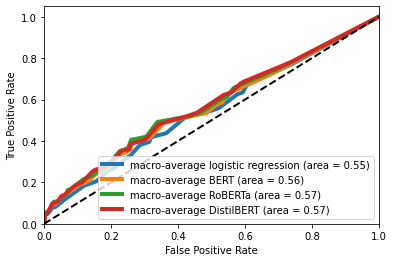

In [86]:
import numpy as np
from sklearn import metrics
from itertools import cycle


n_classes = 13
lw = 2

results = {
    "logistic regression": clf1_results_code,
    "BERT": bert_code,
    "RoBERTa": roberta_code,
    "DistilBERT": distilbert_code}

plt.figure()
for name, result in results.items():
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(13):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_code, result, pos_label=i)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    
    """
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )"""
    label = "macro-average " + name
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=label+" (area = {0:0.2f})".format(roc_auc["macro"]),
        linewidth=4,
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [137]:
labels = ['Solution Discussion', 'Expected Behaviour', 'Usage', 'Social Conversation', 'Contribution and Commitment', 'Bug Reproduction', 'Motivation', 'Potential New Issues and Requests', 'Investigation and Exploration', 'Workarounds', 'Observed Bug Behaviour', 'Task Progress', 'Action on Issue']

def convert_labels(codes):
    new_codes = []
    for i in codes:
        new_codes.append(labels[i])
    return new_codes

In [141]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix

new_roberta = convert_labels(roberta_code)
gt = convert_labels(y_test_code)

    
cf_matrix = confusion_matrix(gt,new_roberta)
print(cf_matrix)

[[  8   0   1   0   0   0   0   0   0   1   2   0   0]
 [  0  20   0   0   5   0   3   2   2  14   0   3   0]
 [  0   0   8   1   0   0   0   1   4   3   0   0   0]
 [  0   0   0  10   1   2   0   0   2   9   0   1   0]
 [  0   4   0   0  24   0   3   3   0  27   1  13   0]
 [  0   1   0   5   0  13   2   0   2  30   2   3   0]
 [  0   6   0   0   6   0   6   0   1   5   0   2   0]
 [  0   3   2   1   3   1   1   9   1  21   1   3   0]
 [  1   0   2   0   4   2   0   2 126  17   2   2   1]
 [  0   5   2   8  14   5   5   7   5 203   6  19   3]
 [  0   0   0   0   0   0   0   1   1   9  12   2   0]
 [  0   2   1   0   0   1   0   0   3  29   1  37   0]
 [  0   1   0   1   0   1   0   0   2   7   0   1   5]]


In [142]:
labels

['Solution Discussion',
 'Expected Behaviour',
 'Usage',
 'Social Conversation',
 'Contribution and Commitment',
 'Bug Reproduction',
 'Motivation',
 'Potential New Issues and Requests',
 'Investigation and Exploration',
 'Workarounds',
 'Observed Bug Behaviour',
 'Task Progress',
 'Action on Issue']

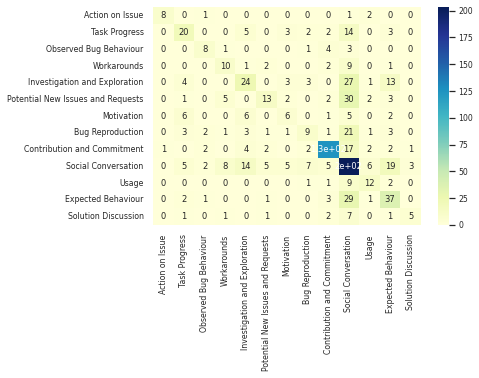

In [150]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cf_matrix, labels[::-1], labels[::-1])
# plt.figure(figsize=(10,7))
sn.set(style="whitegrid", palette="pastel", font_scale=0.7) # for label size
sn.heatmap(df_cm,cmap="YlGnBu", annot=True) # font size

plt.show()